In [1]:
# if you want to run this notebook, you'll need to install
# the Clingo module for Python (https://potassco.org/clingo/)
import clingo

def run(prog):
    ctl = clingo.Control(["0", "--warn=none"])
    ctl.add("base", [], prog)
    ctl.ground([("base", [])])
    with ctl.solve(yield_=True) as handle:
        solution = False
        for m in handle:
            solution = True
            print("Answer:")
            for tup in m.symbols(atoms=True):
                print("\t", tup)
        if not solution:
            print("No model")

# Logic Programming

With [Aaron Bembenek](https://people.seas.harvard.edu/~bembenek/), CS PhD student under Prof. Steve Chong.

**Agenda:**
1. Declarative programming
2. Logic programming basics
3. Negation
4. Summary

```
====================================================================================================
```

## What is an algorithm?

In [2]:
# graph is a map from source vertex to list of neighbors
def mystery_func1(graph):
    m = {}
    for src in graph:
        worklist = list(graph[src])
        visited = set([src])
        reach = [src]
        while worklist:
            dst = worklist.pop() # pop from end of list
            if dst not in visited:
                visited.add(dst)
                reach.append(dst)
                worklist.extend(graph[dst])
        m[src] = reach
    for v in m.values(): v.sort() # for prettier output
    return m

In [3]:
g1 = {
    "a": ["b"],
    "b": ["c"],
    "c": ["b", "d"],
    "d": [],
}

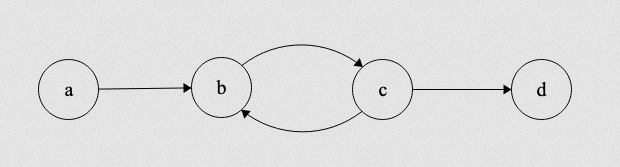

In [4]:
from IPython.display import Image
Image(filename="graph.png", height="100")

In [5]:
mystery_func1(g1)

{'a': ['a', 'b', 'c', 'd'],
 'b': ['b', 'c', 'd'],
 'c': ['b', 'c', 'd'],
 'd': ['d']}

In [6]:
# graph is a map from source vertex to list of neighbors
def mystery_func2(graph):
    m = {}
    for src in graph:
        worklist = list(graph[src])
        visited = set([src])
        reach = [src]
        while worklist:
            dst = worklist.pop(0) # pop from beginning of list
            if dst not in visited:
                visited.add(dst)
                reach.append(dst)
                worklist.extend(graph[dst])
        m[src] = reach
    for v in m.values(): v.sort() # for prettier output
    return m

In [7]:
mystery_func2(g1)

{'a': ['a', 'b', 'c', 'd'],
 'b': ['b', 'c', 'd'],
 'c': ['b', 'c', 'd'],
 'd': ['d']}

**What is the relation between these two algorithms?**

* Solving the same problem
* Using different graph traversals

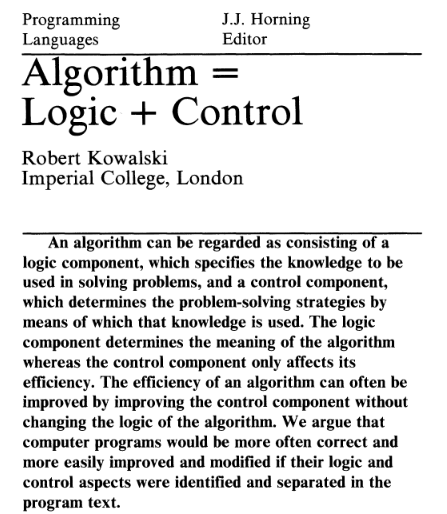

In [8]:
from IPython.display import Image
Image(filename="kowalski.png")

## Declarative programming

- Programmers specify "what" they want to compute
- The language runtime figures out how to compute it

That is: it's **all logic, no control!**

1. What is the logic part of our all-pairs graph reachability algorithm?

- the mathematical definition of graph reachability

2. What is the control part?

- the implementation details: traversal order, visited set, worklist

3. How could we specify the logic more formally?

- for every node X, X reaches itself
- for every node A, B, if there is an edge A to B, then B is reachable from A
- if there is an edge A to B, and C is reachable from B, it's reachable from A

Addendum: One of these rules is redundant. Which one?

In [9]:
reach_prog = """

reach(X, X) :- node(X).

reach(X, Y) :- edge(X, Y).

reach(X, Z) :- edge(X, Y), reach(Y, Z).

node(a).
node(b).
node(c).
node(d).

edge(a, b).
edge(b, c).
edge(c, b).
edge(c, d).

"""

In [10]:
run(reach_prog)

Answer:
	 node(a)
	 node(b)
	 node(c)
	 node(d)
	 reach(a,a)
	 reach(b,b)
	 reach(c,c)
	 reach(d,d)
	 reach(a,b)
	 reach(b,c)
	 reach(c,b)
	 reach(c,d)
	 reach(b,d)
	 reach(a,c)
	 reach(a,d)
	 edge(a,b)
	 edge(b,c)
	 edge(c,b)
	 edge(c,d)


A few things to keep in mind:
- What might be the advantages of declarative programming?
- What might be the disadvantages?

```
====================================================================================================
```

## Logic programming basics


### Syntax

```
Horn clause h   ::=    A :- A, ..., A.
Atom A          ::=    p(t, ..., t)
Term t          ::=    X | f(t, ..., t)
```

- `p` is a predicate symbol
- `X` is a variable
- `f` is an uninterpreted function symbol (i.e., a constructor)

A program consists of a set of Horn clauses.

In a Horn clause, the atom on the left of a `:-` is known as the "head"; the atoms to the right are known as the "body".

A Horn clause with an empty body is known as a "fact" (typically the `:-` is omitted). A Horn clause with a non-empty body is known as a "rule".


Many variants support additional constructs, such as built-in (dis)equality predicates like `t = t` and `t != t`.

### Semantics

What does a logic program mean?

In [11]:
prog = """

p(f(a)).
p(f(a)).

"""
run(prog)

Answer:
	 p(f(a))


In [12]:
prog = """

a.
b :- a.

"""
run(prog)

Answer:
	 a
	 b


In [13]:
prog = """

b :- a.

"""
run(prog)

Answer:


In [14]:
prog = """

n(0).
n(s(K)) :- n(K).
"""
# run(prog)

In [15]:
prog = """

a :- a.

"""
run(prog)

Answer:


There are three traditional (equivalent) semantics defining the meaning of a logic program:
- model theory
- fixpoint theory
- proof theory

We'll look at the first one.

#### Model theory

TL;DR: view rules as logical implications. Meaning is the smallest set of facts including all possible consequences.

Technically, the meaning of a logic program is its **least Herbrand model**.

To form a Herbrand model:

1. Form a ground (variable-free) program: create new versions of each rule, where all the variables have been (consistently) replaced with every possible combination of ground terms.

```
p(X) :- q(X).
s(X) :- r(X, Y).
r(a, b).

    |
    |
    V

p(a) :- q(a).
p(b) :- q(b).
s(a) :- r(a, a).
s(a) :- r(a, b).
s(b) :- r(b, a).
s(b) :- r(b, b).
r(a, b).
```

2. A fact (ground atom) `A` is in the model if there is a ground rule `A :- A1, ..., An.` and `Ai` is in the model for all `i` such that `1 <= i <= n`.

```
r(a, b)
s(a)
```

**Theorem:** for every logic program, there is a least Herbrand model -- i.e., a Herbrand model that is smaller than all others. This means that a logic program is guaranteed to have a single meaning.

**Note:** The Herbrand model might be infinite.

```
p(o).
p(s(X)) :- p(X).
```

General logic programming is Turing-complete!

```
forall X1, ..., Xm. p0(...) <== p1(...) /\ ... /\ pn(...)
```

### Example: Type checking/inference (adapted from Prof. Amin's lecture notes)

Logic programming seems weird... there is no arithmetic, (interpreted) functions, etc. What can we do with it?

Let's build a type checker for expressions in this language:
```
exp e ::= n | x | fun x -> e | e1 e2 | e1 + e2
```

#### Syntactic translation

First, we need a way to translate expressions into logic programming terms:
```
[[ ]] : exp -> LP term

[[n]]          = literal(n)
[[x]]          = var(x)
[[fun x -> e]] = lambda(x, [[e]])
[[e1 e2]]      = apply([[e1]], [[e2]])
[[e1 + e2]]    = plus([[e1]], [[e2]])
```

For example,
```
(fun x -> x + x) 21
```
translates to
```
apply(lambda(x, plus(x, x)), literal(21))
```

#### Typing rules

Now we can write our actual typing rules. We are going to use the following function symbols to represent types: `int` and `arrow`.

```
type(G, literal(X), int).

-----------------
\Gamma |- n : int

type(G, apply(M, N), T) :- type(G, M, arrow(S, T)), type(G, N, S).

\Gamma |- M : S -> T    \Gamma |- N : S
---------------------------------------
\Gamma |- M N : T

type(G, plus(M, N), int) :- type(G, M, int), type(G, N, int).

type(G, lambda(X, M), arrow(S, T)) :- type(cons(pair(X, S), G), M, T).

% Helper
member(X, cons(X, Xs)).
member(X, cons(Y, Xs)) :- member(X, Xs).

type(G, var(X), T) :- member(pair(X, T), G).
```

Correction: Variable lookup does not work in the presence of shadowed variables. How could we fix it?

#### Type checking/inference

**Problem:** This program has an infinite Herbrand model.

**Solution:** Compute only part of Herbrand model necessary for answering a particular query (the approach of Prolog).

To _check_ whether our example expression has type int, use this query:

```
type(nil, apply(lambda(x, plus(x, x)), literal(21)), int)?
```

This is asking: "Does this predicate hold?"

To _infer_ the type of our example expression, use this query:

```
type(nil, apply(lambda(x, plus(x, x)), literal(21)), T)?
```

Note the logic programming variable `T`: this query is saying "Give me all the `T` such that this predicate holds."

## Datalog

Datalog is a popular restricted form of general logic programming:

- All uninterpreted functions are nullary (i.e., they take no arguments; they're constants)
- Every variable appearing in the head of a rule must appear in the body

Not okay: `member(X, cons(Y, Xs)) :- member(X, Xs).`
1. `cons` is not nullary
2. `Y` does not appear in the rule body

These restrictions mean that all Datalog programs have a finite least model; from a practical perspective:
- Evaluating a Datalog program should always terminate
- You do not need to provide a query (although it can be useful for performance)

In fact, Datalog is PTIME-complete, if you consider the rules of a program to be fixed and the facts to be variable.

```
====================================================================================================
```

## Negation

So far, we have considered logic programming without negation. Let's add it.

```
Horn clause h   ::=    A :- L, ... L.
Literal L       ::=    A | not A
Atom A          ::=    p(t, ..., t)
Term t          ::=    X | f(t, ..., t)
```

Now, atoms in rule bodies can be negated.

```
unreach(X, Y) :- not reach(X, Y).
```

Datalog restriction: every variable in a negated atom must also appear in a positive atom in the rule body.

```
unreach(X, Y) :- node(X), node(Y), not reach(X, Y).
```

### The trouble with negation

Example 1:
```
p(a) :- not q(a).

% possibility 1: {}
% possibility 2: { p(a) }
% possibility 3: { q(a) }
```

Example 2:
```
p(a) :- not q(a).
q(a) :- not p(a).
```

Example 3:
```
p(a) :- not p(a).
```

We're no longer guaranteed to have a least model!

### Stratified negation (Datalog)

TL;DR: Restrict allowable programs, so that a program is guaranteed to have a distinguished Herbrand model.

#### Step 1: restrict

A predicate `p` depends negatively on another predicate `q` iff:
- There is a rule with `p` in the head atom and `q` in a _negated_ body atom
- There is a rule with `p` in the head atom and `r` in a body literal, and `r` depends negatively on `q`

If any predicate depends negatively on itself, reject the program!

```
% Reject this program!
p(X) :- q(X).
q(X) :- r(X), not p(X).
```
- `p` is in the head of a rule with `q` in the body
- `q` negatively depends on `p`
- ergo, `p` depends negatively on `p`

#### Step 2: stratify

Partition the predicates into _strata_, so that predicates in stratum `i` depend only on predicates in strata `j` for `j <= i`.

**Theorem:** A program that passes step 1 is guaranteed to be stratifiable so that, if `p` depends negatively on `q`, then `q` is in a lower stratum than `p`.

#### Step 3: construct distinguished model

1. Find a model for stratum 1.
2. Use it to "seed" the model for stratum 2 -- i.e., find a model for stratum 2, assuming the model for stratum 1 holds.
3. Repeat for stratum 3 (using the model for stratum 2 as the "seed"), and so on...

In [16]:
unreach_prog = """

% stratum 1
reach(X, X) :- node(X).
reach(X, Y) :- edge(X, Y).
reach(X, Z) :- edge(X, Y), reach(Y, Z).

% stratum 2
unreach(X, Y) :- node(X), node(Y), not reach(X, Y).

node(a).
node(b).
node(c).
node(d).

edge(a, b).
edge(b, c).
edge(c, b).
edge(c, d).

"""
run(unreach_prog)

Answer:
	 node(a)
	 node(b)
	 node(c)
	 node(d)
	 reach(a,a)
	 reach(b,b)
	 reach(c,c)
	 reach(d,d)
	 reach(a,b)
	 reach(b,c)
	 reach(c,b)
	 reach(c,d)
	 reach(b,d)
	 reach(a,c)
	 reach(a,d)
	 edge(a,b)
	 edge(b,c)
	 edge(c,b)
	 edge(c,d)
	 unreach(b,a)
	 unreach(c,a)
	 unreach(d,a)
	 unreach(d,b)
	 unreach(d,c)


In [17]:
example1 = """

p(a) :- not q(a).

% possible solution #1: { q(a) }
% possible solution #2: { p(a) }

% stratum 1: { q } --> model = {}
% stratum 2: { p } --> model = { p(a) }

"""
run(example1)

Answer:
	 p(a)


Pros with stratified negation:
- Intuitive
- Easy to compute

Cons
- We cannot assign a meaning to all programs (e.g., examples 2 and 3)

### Stable models (answer set programming)

TL;DR: do not restrict uses of negation, and allow for zero, one, or more (stable) models

#### Step 1: ground program

...as we discussed in section on logic programming semantics.

```
p(X) :- r(X), not q(X).
q(X) :- r(X), not p(X).
r(a).

    |
    |
    V

p(a) :- not q(a), r(a).
q(a) :- not p(a), r(a).
r(a).
```

#### Step 2: form reduct

Choose a set of ground facts `S`.

Rewrite the program:
- If the ground program contains a rule with a body literal `not A` for some `A` in `S`, remove that rule from the program.
- If the ground program contains a rule with a body literal `not A` for some `A` _not_ in `S`, remove that literal from the rule.

This program is known as the reduct w.r.t. `S`. **It will have no negation.**

Say we have this program:
```
p(a) :- not q(a), r(a).
q(a) :- not p(a), r(a).
r(a).
```

The reduct of this program with respect to the set `S = { p(a), r(a) }` is this program:
```
p(a) :- r(a).
r(a).
```

#### Step 3: confirm stable model

Find the least model of the reduct. If this model is equivalent to `S`, then `S` is a stable model -- that is, a solution to our logic program.

In our example, `S = { p(a), r(a) }` is a stable model. The other stable model is `{ q(a), r(a) }`.

In [18]:
prog = """
p(X) :- not q(X), r(X).
q(X) :- not p(X), r(X).
r(a).
"""
run(prog)

Answer:
	 r(a)
	 q(a)
Answer:
	 r(a)
	 p(a)


How about this program? Think it through with your neighbor.

In [19]:
prog = """
p(a) :- not p(a).

% choice 1: S = { p(a) }
% choice 2: S = {}
"""
run(prog)

No model


Pros of stable model semantics:
- Can assign a meaning to programs with unrestricted uses of negation

Cons:
- Programs no longer have single solutions
- Harder to compute
    - Finding whether a stable model exists is NP-complete (assuming that all function symbols are nullary)

**Something to think about:** What is the relation between the stratified semantics and the stable model semantics? 

- If a program is stratifiable, how many stable models does it have?
- Do any of the stable models correspond to the model chosen under the stratified semantics?

```
====================================================================================================
```

## Summary

1. Logic programming is a form of declarative programming
    - Programmer focuses on the **logic** of the computation (i.e., the "what")
    - Runtime system takes care of the **control** (i.e, the "how")
2. Logic programming semantics are straightforward when there is no negation
3. Life gets a lot more difficult when you introduce negation
    - But the resulting languages are more useful/powerful

Big topics we haven't adequately addressed:
- Prolog, the original (and a very popular) logic programming language
- How logic programming languages are implemented (the "control" part)
- Logic programming applications: AI, databases, constraint solving, ...

|                        | Complexity      | Applications |
|:-----------------------|:----------------|:-------------|
| Prolog                 | Turing-complete | <ul><li>originally, natural language processing</li><li>expert systems</li><li>general computing</li></ul> |
| Datalog                | PTIME-complete  | <ul><li>originally, database query language (SQL + recursion)</li><li>static program analysis</li><li>declarative networking</li><li>policy/protocol modeling</li></ul> |
| Answer set programming | NP-complete     | <ul><li>constraint solving</li><li>scheduling and planning</li><li>other AI</li></ul>|